<div style="background:#F5F7FA; height:100px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Want to do more?</span><span style="border: 1px solid #3d70b2;padding: 15px;float:right;margin-right:40px; color:#3d70b2; "><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
<span style="color:#5A6872;"> Try out this notebook with your free trial of IBM Watson Studio.</span>
</div>

<table style="border: none" align="left">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="4" color="black"><b>Use TensorFlow to predict hand-written digits</b></font></font></th>
      <th style="border: none"><img src="https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true" alt="Watson Machine Learning icon" height="40" width="40"></th>
   </tr> 
   <tr style="border: none">
       <td style="border: none"><img src="https://github.com/pmservice/wml-sample-models/raw/master/scikit-learn/hand-written-digits-recognition/images/numbers_banner-04.png" width="600" alt="Icon"></td>
   </tr>
</table>

This notebook contains steps and code to demonstrate support of Deep Learning model training and scoring in Watson Machine Learning service. This notebook introduces commands for getting data, training_definition persistance to Watson Machine Learning repository, model training, model persistance, model deployment and scoring.

Some familiarity with Python is helpful. This notebook uses Python 3.


## Learning goals

The learning goals of this notebook are:

-  Working with Watson Machine Learning service.
-  Training Deep Learning models (TensorFlow).
-  Saving trained models in Watson Machine Learning repository.
-  Online deployment and scoring of trained model.


## Contents

This notebook contains the following parts:

1.	[Setup](#setup)
2.	[Train TensorFlow model](#model)
3.	[Persist model](#save)
4.	[Deploy model](#deploy)
5.	[Score](#scoring)
6.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a [Watson Machine Learning (WML) Service](https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/) instance (a free plan is offered and information about how to create the instance is [here](https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html))
-  Create a [Cloud Object Storage (COS)](https://console.bluemix.net/catalog/infrastructure/cloud-object-storage) instance (a lite plan is offered and information about how to order storage is [here](https://console.bluemix.net/docs/services/cloud-object-storage/basics/order-storage.html#order-storage)).
    - After you create COS instance, go to your COS dashboard.
    - In **Service credentials** tab, click **New Credential**.
    - Add the inline configuration parameter: {["HMAC"](https://console.bluemix.net/docs/services/cloud-object-storage/hmac/credentials.html#using-hmac-credentials):true}, click **Add**.

    This configuration parameter adds the following section to the instance credentials, (for use later in this notebook):
    ```
      "cos_hmac_keys": {
            "access_key_id": "722432c254bc4eaa96e05897bf2779e2",
            "secret_access_key": "286965ac10ecd4de8b44306288c7f5a3e3cf81976a03075c"
       }
    ```

### 1.1 Working with Cloud Object Storage

`ibm-cos-sdk` library allows Python developers to manage Cloud Object Storage (COS).

In [1]:
import ibm_boto3
from ibm_botocore.client import Config

Enter your COS credentials in the following cell. 
You can find these credentials in your COS instance dashboard under the **Service credentials** tab.
**Note** the HMAC key, described in [set up the environment](#setup) is included in these credentials.

In [2]:
cos_credentials = {
  "apikey": "***",
  "cos_hmac_keys": {
    "access_key_id": "***",
    "secret_access_key": "***"
  },
  "endpoints": "https://cos-service.bluemix.net/endpoints",
  "iam_apikey_description": "Auto generated apikey during resource-key operation for Instance - crn:v1:bluemix:public:cloud-object-storage:global:a/07a95aa44e6124e8b320b70cf88033fa:876e5285-4bef-4cf3-a89b-595e19648c7c::",
  "iam_apikey_name": "auto-generated-apikey-19a79dae-6a58-4b4f-878f-6839b711523f",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/07a95aa44e6124e8b320b70cf88033fa::serviceid:ServiceId-3f2cccee-61ec-4147-8732-9f58479ba26a",
  "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/07a95aa44e6124e8b320b70cf88033fa:876e5285-4bef-4cf3-a89b-595e19648c7c::"
}

In [3]:
# The code was removed by DSX for sharing.

Define the endpoint you will use. 

1. To do this, first enter your COS credentials in the following cell. 
You can find these credentials in your COS instance dashboard under the **Service credentials** tab.
**Note** the HMAC key, described in [set up the environment](#setup) is included in these credentials.

2. Go to the **Endpoint** tab in the COS instance's dashboard to get the endpoint information.

In [4]:
service_endpoint = 'https://s3-api.us-geo.objectstorage.softlayer.net'

You also need IBM Cloud authorization endpoint to be able to create COS resource object.

In [5]:
auth_endpoint = 'https://iam.bluemix.net/oidc/token'

We create COS resource to be able to write data to Cloud Object Storage.

In [6]:
cos = ibm_boto3.resource('s3',
                         ibm_api_key_id=cos_credentials['apikey'],
                         ibm_service_instance_id=cos_credentials['resource_instance_id'],
                         ibm_auth_endpoint=auth_endpoint,
                         config=Config(signature_version='oauth'),
                         endpoint_url=service_endpoint)

Let's create the buckets (they have to have unique names), we will use to store training data and training results.

In [7]:
from uuid import uuid4

bucket_uid = str(uuid4())
buckets = ['training-data-' + bucket_uid, 'training-results-' + bucket_uid]

for bucket in buckets:
    if not cos.Bucket(bucket) in cos.buckets.all():
        print('Creating bucket "{}"...'.format(bucket))
        try:
            cos.create_bucket(Bucket=bucket)
        except ibm_boto3.exceptions.ibm_botocore.client.ClientError as e:
            print('Error: {}.'.format(e.response['Error']['Message']))

Creating bucket "training-data-38a61fd8-a250-4a82-9277-ef51f88bfadb"...
Creating bucket "training-results-38a61fd8-a250-4a82-9277-ef51f88bfadb"...


Now we should have 2 buckets,

### 1.2 Downloading training data and upload it to COS buckets.

Let's download our training data and upload them to 'training-data' bucket.
We will create a list of links for training dataset

In [8]:
data_links = ['http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
              'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
              'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
              'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz']

Below snippet will upload files from links to your Cloud Object Storage.

In [9]:
from urllib.request import urlopen

bucket_obj = cos.Bucket(buckets[0])

for data_link in data_links:
    filename=data_link.split('/')[-1]
    print('Uploading data {}...'.format(filename))
    with urlopen(data_link) as data:
        bucket_obj.upload_fileobj(data, filename)
        print('{} is uploaded.'.format(filename))

Uploading data train-images-idx3-ubyte.gz...
train-images-idx3-ubyte.gz is uploaded.
Uploading data train-labels-idx1-ubyte.gz...
train-labels-idx1-ubyte.gz is uploaded.
Uploading data t10k-images-idx3-ubyte.gz...
t10k-images-idx3-ubyte.gz is uploaded.
Uploading data t10k-labels-idx1-ubyte.gz...
t10k-labels-idx1-ubyte.gz is uploaded.


Let's see the list of all created buckets and their contents.

In [10]:
for bucket_name in buckets:
    print(bucket_name)
    bucket_obj = cos.Bucket(bucket_name)
    for obj in bucket_obj.objects.all():
        print("  File: {}, {:4.2f}kB".format(obj.key, obj.size/1024))

training-data-38a61fd8-a250-4a82-9277-ef51f88bfadb
  File: t10k-images-idx3-ubyte.gz, 1610.23kB
  File: t10k-labels-idx1-ubyte.gz, 4.44kB
  File: train-images-idx3-ubyte.gz, 9680.10kB
  File: train-labels-idx1-ubyte.gz, 28.20kB
training-results-38a61fd8-a250-4a82-9277-ef51f88bfadb


We are done with Cloud Object Storage, we are ready to train our model!

<a id="model"></a>
## 2. Train model

### 2.1 Work with the instance

**Hint:** You may need to install wget using following command `!pip install wget`

In [13]:
import urllib3, requests, json, base64, time, os, wget

Authenticate to Watson Machine Learning service on IBM Cloud.

**Action**: Put authentication information from your instance of Watson Machine Learning service here.

In [11]:
wml_credentials = {
  "url": "https://ibm-watson-ml.mybluemix.net",
  "access_key": "vgXPA8k5Ld613WJP/S0ijQZtiitjuwsj9qpVt+nvl9DFl8PK/67XgmnreKabd2ZPpxSFKe9cZoFYLlzgPf++qpWZYcc+6fawL9S0V+2V79Adc+zik+ZHJYrsBRl9GAcs",
  "username": "***",
  "password": "***",
  "instance_id": "***"
}

In [33]:
# The code was removed by DSX for sharing.

#### Install `watson-machine-learning-client` from pypi

In [15]:
!rm -rf $PIP_BUILD/watson-machine-learning-client

In [16]:
!pip install watson-machine-learning-client --upgrade

Requirement already up-to-date: watson-machine-learning-client in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages
Requirement not upgraded as not directly required: tqdm in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: pandas in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: requests in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: urllib3 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: lomond in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: certifi in /opt/conda/envs/DSX-Python35/lib/p

#### Import `watson-machine-learning-client` and authenticate to service instance

In [ ]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

**Note:** Deprecation warning is returned from scikit-learn package and does not impact watson machine learning client functionalities.

In [18]:
client = WatsonMachineLearningAPIClient(wml_credentials)

### 2.2 Save model definition 

#### Prepare model definition metadata

In [19]:
model_definition_metadata = {
            client.repository.DefinitionMetaNames.NAME: "My definition name",
            client.repository.DefinitionMetaNames.DESCRIPTION: "My description",
            client.repository.DefinitionMetaNames.AUTHOR_NAME: "John Smith",
            client.repository.DefinitionMetaNames.FRAMEWORK_NAME: "tensorflow",
            client.repository.DefinitionMetaNames.FRAMEWORK_VERSION: "1.5",
            client.repository.DefinitionMetaNames.RUNTIME_NAME: "python",
            client.repository.DefinitionMetaNames.RUNTIME_VERSION: "3.5",
            client.repository.DefinitionMetaNames.EXECUTION_COMMAND: "python3 tensorflow_mnist_softmax.py --trainingIters 20"
            }

#### Get sample model definition content file from git

In [21]:
filename='tf-softmax-model.zip'

if not os.path.isfile(filename):
    filename = wget.download('https://github.com/pmservice/wml-sample-models/raw/master/tensorflow/hand-written-digit-recognition/definition/tf-softmax-model.zip')
    
print(filename)

tf-softmax-model.zip


#### Publish training definition in Watson Machine Learning repository

In [22]:
definition_details = client.repository.store_definition(filename, model_definition_metadata)

In [23]:
definition_uid = client.repository.get_definition_uid(definition_details)

In [24]:
print(definition_uid)

60994f57-61e6-4bcc-b025-18622d22c98f


### 2.3 Train model

#### Prepare training configuration

**Action:** Put authentication information from your instance of Object Storage service here.
- `TRAINING_DATA_REFERENCE` (reference to uploaded training data)
- `TRAINING_RESULTS_REFERENCE` (location where trained model will be saved)

In [25]:
training_configuration_metadata = {
            client.training.ConfigurationMetaNames.NAME: "Hand-written Digit Recognition",
            client.training.ConfigurationMetaNames.AUTHOR_NAME: "John Smith",
            client.training.ConfigurationMetaNames.DESCRIPTION: "Hand-written Digit Recognition training",
            client.training.ConfigurationMetaNames.TRAINING_DATA_REFERENCE: {
                    "connection": {
                        "endpoint_url": service_endpoint,
                        "aws_access_key_id": cos_credentials['cos_hmac_keys']['access_key_id'],
                        "aws_secret_access_key": cos_credentials['cos_hmac_keys']['secret_access_key']
                    },
                    "source": {
                        "bucket": buckets[0],
                    },
                    "type": "s3"
                },
            client.training.ConfigurationMetaNames.TRAINING_RESULTS_REFERENCE: {
                "connection": {
                    "endpoint_url": service_endpoint,
                    "aws_access_key_id": cos_credentials['cos_hmac_keys']['access_key_id'],
                    "aws_secret_access_key": cos_credentials['cos_hmac_keys']['secret_access_key']
                },
                "target": {
                    "bucket": buckets[1],
                },
                "type": "s3"
            },
        }

#### Train the model in the background

In [26]:
training_run_details = client.training.run(definition_uid, training_configuration_metadata)

In [27]:
training_run_guid_async = client.training.get_run_uid(training_run_details)

You can check status of training run by calling the method below.

In [34]:
status = client.training.get_status(training_run_guid_async)
print(json.dumps(status, indent=2))

{
  "state": "completed",
  "message": "",
  "current_at": "2018-03-28T07:58:31Z",
  "metrics": [],
  "running_at": "2018-03-28T07:56:56Z",
  "finished_at": "2018-03-28T07:58:17Z",
  "submitted_at": "2018-03-28T07:56:19Z"
}


#### Monitor training log

You can turn on training log monitoring by calling the method below.

In [ ]:
client.training.monitor_logs(training_run_guid_async)



########################################################

Log monitor started for training run: training-r5rli_Rig

########################################################




#### Cancel training

You can cancel the training run by calling the method below.

#### Train the model in active mode

**Tip:** You can also run training in synchronous mode by setting `asynchronous = False`

<a id="model"></a>
## 3. Persist model

#### Call this method to the save model in Watson Machine Learning repository

In [35]:
saved_model_details = client.repository.store_model(training_run_guid_async, {"name": "My cool mnist model"})

In [36]:
print("Url: " + client.repository.get_model_url(saved_model_details))

Url: https://ibm-watson-ml.mybluemix.net/v3/ml_assets/models/97822727-4bd1-4df0-95df-8ff9536ea01d


**Tip:** Run the code below to extract the stored model uid from the dictionary.

In [37]:
model_uid = client.repository.get_model_uid(saved_model_details)
print("Saved model uid: " + model_uid)

Saved model uid: 97822727-4bd1-4df0-95df-8ff9536ea01d


#### Call this method to list stored models

In [37]:
client.repository.list_models()

------------------------------------  ----------------------------------------  ------------------------  -----------------
GUID                                  NAME                                      CREATED                   FRAMEWORK
cc574a1a-b9f9-4180-a4a3-53b1b715d9e6  Product Line Prediction                   2017-12-02T10:10:03.467Z  mllib-2.0
7aee2225-3bbe-400f-8043-e1bd4513a5ce  Customer Satisfaction Prediction          2018-01-11T12:12:53.746Z  MLlib-2.0
ebb88315-b8c7-42cf-9bf1-d9e688fbeedf  Product Line Prediction                   2018-01-11T12:13:55.046Z  MLlib-2.0
75cf4602-91cb-4177-9260-1187f7e66f39  Customer Satisfaction Prediction          2018-01-11T12:14:27.145Z  MLlib-2.0
37635f9d-61a0-4e55-b316-251274afca71  Sentiment Prediction                      2018-01-11T12:14:30.549Z  MLlib-2.0
407f4db1-ba65-4ffb-93d8-97961c763047  Best Heart Drug Selection                 2018-01-11T12:14:35.179Z  MLlib-2.0
34c062ba-fb5a-41d7-ab8e-a0d2413fa731  myModel                   

#### Delete training-run and its results

You can delete train runs and results by running the code in the following cell.

## 5. Create online deployment

You can deploy the stored model as a web service (online) by running code in the following cell.

In [38]:
deployment_details = client.deployments.create(model_uid, "Mnist model deployment")



#######################################################################################

Synchronous deployment creation for uid: '4bcae2dc-b309-4e0d-8858-2c04fe4c6383' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='4bcae2dc-b309-4e0d-8858-2c04fe4c6383'
------------------------------------------------------------------------------------------------




In [39]:
scoring_url = client.deployments.get_scoring_url(deployment_details)
print(scoring_url)

https://ibm-watson-ml.mybluemix.net/v3/wml_instances/3f6e5c2b-4880-46aa-9d79-62e90ccc9d56/published_models/97822727-4bd1-4df0-95df-8ff9536ea01d/deployments/4bcae2dc-b309-4e0d-8858-2c04fe4c6383/online


## 6. Scoring

Prepare sample scoring data to score deployed model.

In [40]:
image1 = [0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.639,0.757,0.596,0.361,0.200,0.200,0.200,0.200,0.122,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.082,0.875,0.992,0.988,0.992,0.988,0.992,0.988,0.992,0.753,0.322,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.200,0.992,0.400,0.000,0.082,0.400,0.243,0.400,0.400,0.239,0.718,0.157,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.200,0.988,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.239,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.200,0.992,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.361,0.988,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.678,0.992,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.992,0.988,0.875,0.796,0.796,0.796,0.322,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.482,0.996,0.992,0.878,0.796,0.796,0.875,0.996,0.278,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.161,0.953,0.992,0.510,0.078,0.000,0.000,0.078,0.992,0.910,0.161,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.596,0.992,0.718,0.000,0.000,0.000,0.000,0.000,0.518,0.992,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.200,0.592,0.078,0.000,0.000,0.000,0.000,0.000,0.200,0.988,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.082,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.443,0.992,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.322,0.718,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.757,0.988,0.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.796,0.718,0.000,0.000,0.000,0.000,0.000,0.000,0.082,0.996,0.992,0.161,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.082,0.875,0.400,0.000,0.000,0.000,0.000,0.000,0.082,0.796,0.992,0.510,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.800,0.482,0.000,0.000,0.000,0.000,0.161,0.678,0.992,0.796,0.078,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.635,0.875,0.400,0.082,0.400,0.639,0.953,0.992,0.671,0.078,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.161,0.918,0.992,1.000,0.992,1.000,0.675,0.322,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.118,0.514,0.753,0.435,0.196,0.039,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000]
image2 = [0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.196,0.878,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.275,0.114,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.475,0.906,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.580,0.659,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.016,0.765,0.906,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.376,0.824,0.043,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.271,0.988,0.525,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.447,0.988,0.082,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.176,0.925,0.851,0.047,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.753,0.988,0.082,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.659,0.969,0.208,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.071,1.000,0.992,0.082,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.329,0.949,0.827,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.553,0.992,0.741,0.020,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.663,0.988,0.416,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.125,0.910,0.980,0.259,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.059,0.882,0.988,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.525,0.988,0.827,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.086,0.988,0.643,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.663,0.988,0.655,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.035,0.800,0.820,0.071,0.000,0.000,0.000,0.000,0.000,0.000,0.086,0.992,0.992,0.420,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.663,0.988,0.780,0.333,0.333,0.333,0.333,0.506,0.643,0.765,0.988,0.988,0.416,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.161,0.667,0.961,0.988,0.988,0.988,0.988,0.910,0.906,0.984,0.988,0.988,0.035,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.192,0.329,0.329,0.329,0.329,0.000,0.000,0.631,0.988,0.988,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.498,0.988,0.988,0.176,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.502,0.992,0.992,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.498,0.988,0.988,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.529,0.988,0.957,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.910,0.925,0.435,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.702,0.259,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000]

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

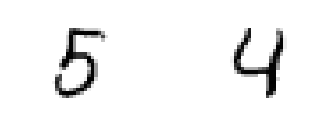

In [42]:
for i, image in enumerate([image1, image2]):
    plt.subplot(2, 2, i + 1)
    plt.axis('off')
    plt.imshow( (np.reshape(image, (28, 28)) * 255).astype(np.uint8), cmap=plt.cm.gray_r, interpolation='nearest')

Build scoring disctionary consisting of two digits and send it to deployed model to get predictions.

In [43]:
scoring_data = {'values': [image1, image2]}

In [44]:
predictions = client.deployments.score(scoring_url, scoring_data)
print("Scoring result: " + str(predictions))

Scoring result: {'values': [5, 4]}


<a id="summary"></a>
## 6. Summary and next steps     

 You successfully completed this notebook! You learned how to use `watson-machine-learning-client` to train and score TensorFlow models. Check out our [Online Documentation](https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html) for more samples, tutorials, documentation, how-tos, and blog posts. 

### Authors

**Lukasz Cmielowski**, PhD, is a Automation Architect and Data Scientist at IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.

Copyright © 2017, 2018 IBM. This notebook and its source code are released under the terms of the MIT License.